# Введение библиотек, обозначение пути, загрузка данных

In [1]:
import os
RAW_DATA_DIR = 'data/raw/'
OUTPUT_DATA_DIR = 'data/output/'
PRO_DATA_DIR = 'products'
PRODUCTS_DIR = os.path.join(RAW_DATA_DIR, PRO_DATA_DIR)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
# объединение партиций продуктов

partitions = []
for directory in tqdm(os.listdir(PRODUCTS_DIR)):
    for path in os.listdir(os.path.join(PRODUCTS_DIR, directory)):
        next_partition = pd.read_csv(os.path.join(PRODUCTS_DIR, directory, path)).astype({
        "user_id": "int32", "order_id": "int32", "line_item_id": "int32", "price": "float32",
        "discount": "float32", "quantity": "int32", "product_id": "int32", "master_category_id": "Int32", "parent_category_id": "int32"
        })
        partitions.append(next_partition)
        

products = pd.concat(partitions)

100%|██████████| 6/6 [01:17<00:00, 12.83s/it]


In [4]:
orders = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_1_orders.csv")).astype({
    "order_id": "int32", "user_id": "int32", "store_id": "int32"
})
product_properties = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_5_product_properties.csv")).astype({
    "product_id": "int32"
})
categories = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_3_categories.csv"))
city = pd.read_csv(os.path.join(RAW_DATA_DIR, "tab_6_city.csv"))
user_profiles = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_4_user_profiles.csv")).astype({
    "user_id": "int32"
})

In [5]:
import gc

del partitions

gc.collect()

67

In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59596980 entries, 0 to 2703094
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             int32  
 1   order_id            int32  
 2   line_item_id        int32  
 3   price               float32
 4   quantity            int32  
 5   discount            float32
 6   product_name        object 
 7   product_id          int32  
 8   brand_name          object 
 9   master_category_id  Int32  
 10  parent_category_id  int32  
dtypes: Int32(1), float32(2), int32(6), object(2)
memory usage: 3.4+ GB


# Удаление простого мусора и проверка

## Продукты

In [7]:
products["brand_name"] = products["brand_name"].replace(["Без бренда",'-','No brand'], np.nan)
products = products.dropna(subset=['price', 'discount', 'quantity', 'product_name'])
products = products[products['price']>0]
products = products[products['quantity']>0]
products = products[products['discount']>=0]

# проверка
[products.isna().sum(),
len(products[products["price"] <= 0]),
len(products[products["quantity"] <= 0]),
len(products[products["discount"] < 0])]

[user_id                     0
 order_id                    0
 line_item_id                0
 price                       0
 quantity                    0
 discount                    0
 product_name                0
 product_id                  0
 brand_name            7693091
 master_category_id      10797
 parent_category_id          0
 dtype: int64,
 0,
 0,
 0]

## Свойства продуктов

In [8]:
product_properties.isna().sum(axis=0)

product_id        0
property_name     0
property_value    1
dtype: int64

In [9]:
product_properties[product_properties['property_value'].isna()]

,product_id,property_name,property_value
644240,84195,ingredients,NaN


In [10]:
# состав не может быть пустым
product_properties = product_properties.dropna(subset=['property_value'])

# Заказы

In [11]:
orders["platform"] = orders["platform"].replace("undefined", np.nan)
orders.isna().sum(axis=0)

user_id                   0
order_id                  0
order_created_time        0
retailer                  0
store_id                  0
platform              76536
dtype: int64

In [12]:
orders = orders[orders["order_id"].isin(products["order_id"])]

# Пользователи

In [13]:
user_profiles['user_id'] = user_profiles['user_id'].astype('Int32')

In [14]:
user_profiles = user_profiles[user_profiles["user_id"].isin(products["user_id"])]

## Приведение даты рождения к одному виду

In [15]:
from datetime import datetime

def to_date(date):
    
    if pd.isna(date):  # пропущенные значения
        return date
    
    formats = ['%Y-%m-%d', '%m.%d.%Y', '%d.%m.%Y']
    for fmt in formats:
        try:
            return datetime.strptime(date, fmt).strftime("%Y-%m-%d")  # привести все даты к одному формату
        except ValueError:
            pass
    
    print(f"Couldn't process {date}")

In [16]:
user_profiles["bdate"] = user_profiles["bdate"].apply(to_date)

Couldn't process 16.5
Couldn't process 30.4
Couldn't process 12.9
Couldn't process 6.1
Couldn't process 6.9
Couldn't process 3.2
Couldn't process 7.10
Couldn't process 24.5
Couldn't process 29.1
Couldn't process 1.1
Couldn't process 16.11
Couldn't process 22.12
Couldn't process 15.8
Couldn't process 25.2
Couldn't process 1.4
Couldn't process 1.1
Couldn't process 10.6
Couldn't process 2.8
Couldn't process 16.9
Couldn't process 23.8
Couldn't process 27.12
Couldn't process 30.8
Couldn't process 25.5
Couldn't process 1.1
Couldn't process 16.1
Couldn't process 17.2
Couldn't process 25.10
Couldn't process 17.3
Couldn't process 23.10
Couldn't process 1.1
Couldn't process 10.2
Couldn't process 21.11
Couldn't process 1.10
Couldn't process 29.6
Couldn't process 3.5
Couldn't process 1.1
Couldn't process 24.3
Couldn't process 18.8
Couldn't process 10.12
Couldn't process 13.8
Couldn't process 29.6
Couldn't process 5.11
Couldn't process 6.8
Couldn't process 19.11
Couldn't process 1.1
Couldn't proces

In [17]:
user_profiles["bdate"]

0                NaN
1         1987-10-11
2                NaN
3                NaN
4                NaN
             ...    
438784    1989-02-21
438799    1987-08-07
438829    1980-02-21
438859    1997-12-01
438866    1981-07-22
Name: bdate, Length: 92182, dtype: object

# Города

In [18]:
city['store_id'] = city['store_id'].astype('Int32')

## Удаление пробелов в названиях

думаю, это не надо делать, так как это часть задачи участника по работе с текстом (очистка текстов - важная часть NLP пайплайна) - комментарий Дани Гафни

In [19]:
# def ohne_probel(text):
#     try:
#         words = text.split()
#         words = ' '.join(words)
#         return words
#     except AttributeError:
#         return text

In [20]:
# products['brand_name']=products['brand_name'].apply(ohne_probel)
# products['product_name']=products['product_name'].apply(ohne_probel)
# product_properties['property_name']=product_properties['property_name'].apply(ohne_probel)
# product_properties['property_value']=product_properties['property_value'].apply(ohne_probel)
# orders['retailer'] = orders['retailer'].apply(ohne_probel)

# Очистка пользователей B2B

In [21]:
# введем столбец (количество) * (цена) = (полная стоимость товара)
products.insert(5, "Sumprice", (products['quantity'] * products['price']).rename("sumprice").astype("float32"), True)

## Найдем общую стоимость каждого заказа

In [22]:
sum_order = products.groupby(["order_id"])["Sumprice"].sum()

<AxesSubplot:>

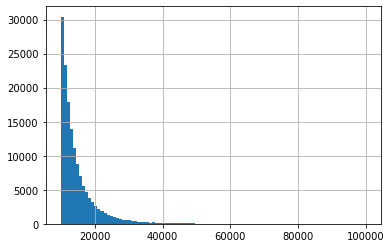

In [23]:
sum_order[(100000>sum_order)&(10000<sum_order)].hist(bins=100)

Видно, что это почти непрерывная экспонента, правильнее всего оборвать тогда, когда заканчивается непрерывность.

<AxesSubplot:>

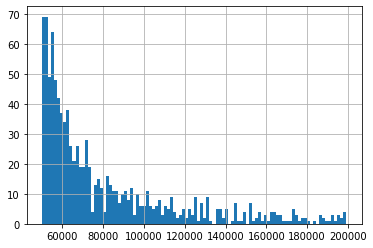

In [24]:
sum_order[(200000>sum_order)&(50000<sum_order) ].hist(bins =100)

Возьму ограничение в 80к на общую стоимость заказа

In [25]:
products = products[~products["order_id"].isin(sum_order[(80000<sum_order)].index.get_level_values('order_id'))]

In [26]:
del sum_order

gc.collect()

40

# Фильтры
Но все равно некоторые товары очевидно куплены не для личного пользования - 100 пачек кофе, например

Посмотрев на график зависимости количества одинаковых товаров от их суммарной стоимости, я пришел к выводу использования 4 фильтров:

1) 1 или 2 товара могут быть любой стоимости

2) Суммарная стоимость любого количества товаров не больше 1000

3) почти все продукты находятся под прямой (количество)/40 + (суммарная цена)/10000 = 1

4) питьевые жидкости и кормы для животных под прямой (количество)/80 + (суммарная цена)/15000) = 1

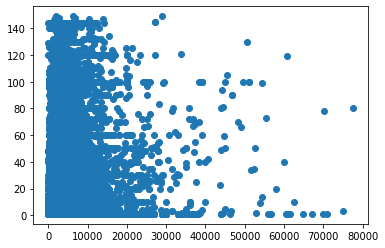

In [27]:
#на графике не указаны точки с количеством больше 150, для наглядности
# до применения фильтров:
plt.scatter(products[(products['quantity']<150)]['Sumprice'], products[(products['quantity']<150)]['quantity'])

In [28]:
# после применения фильтров:
# plt.scatter(products[(products['quantity'] <= 2) | ((products['Sumprice']<140) | (products['quantity']/30 + products['Sumprice']/7500 <1) | (((products['parent_category_id']==345)|(products['parent_category_id']==74))&((products['quantity']/50+products['Sumprice']/10000)<1)))]['Sumprice'], products[(products['quantity'] <= 2) | ((products['Sumprice']<140) | (products['quantity']/30 + products['Sumprice']/7500 <1) | (((products['parent_category_id']==345)|(products['parent_category_id']==74))&((products['quantity']/50+products['Sumprice']/10000)<1)))]['quantity'])
#на графике не указаны точки с количеством больше 45, для наглядности

In [29]:
products = products[(~products["user_id"].isin(products[(products['quantity'] > 2) & (products['Sumprice']>1000) & ((products['quantity']/40 + products['Sumprice']/10000 > 1) | (((products['parent_category_id']==345)|(products['parent_category_id']==74))&((products['quantity']/80+products['Sumprice']/15000)>1)))]['user_id'].values))&(products['quantity']<80)&(products['Sumprice']<20000)]

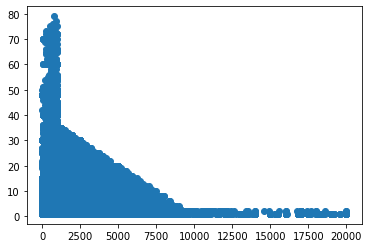

In [30]:
# так выглядят очищенные данные
plt.scatter(products['Sumprice'], products['quantity'])

## Найдем потраченные деньги пользователеми с больше 5 заказов и разделим на интервал покупок

In [31]:
products = products.merge(orders[["order_id", "order_created_time"]], on="order_id", how="inner")

In [32]:
products["order_created_time"] = pd.to_datetime(products["order_created_time"])

In [33]:
user_products = products.groupby("user_id")

In [34]:
user_order_count = user_products["order_id"].count().rename("order_count").reset_index()

In [35]:
users_with_more_than_5_orders = user_order_count[user_order_count["order_count"] > 5]["user_id"]

In [36]:
users_with_more_than_5_orders

0              83
3             224
4             260
5             353
6             400
           ...   
622524    3142899
622526    3142924
622527    3142936
622528    3142965
622529    3142966
Name: user_id, Length: 584425, dtype: int64

Будем дальше работать только с этими пользователями с больше чем 5 заказами

In [37]:
user_products = products[products["user_id"].isin(users_with_more_than_5_orders)].groupby("user_id")

In [38]:
user_weekly_spendings = (user_products["price"].sum() / \
                         ((user_products["order_created_time"].max() - user_products["order_created_time"].min())\
                          .astype("int64") / (1e9 * 60 * 60 * 24 * 7))).reset_index().rename(columns={0: "weekly_spendings"})

Затраты на покупки в неделю

<AxesSubplot:>

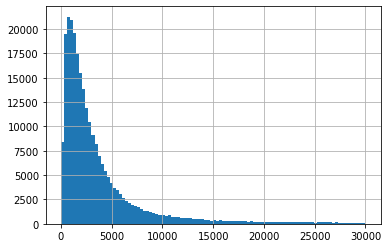

In [39]:
user_weekly_spendings[(user_weekly_spendings["weekly_spendings"] != np.inf) & 
                      (user_weekly_spendings["weekly_spendings"] < 30000)]["weekly_spendings"].hist(bins=100)

### Магазины, где совершают заказы пользователи, которые тратят больше 10000 в неделю

In [40]:
orders[orders["user_id"].isin(user_weekly_spendings[(user_weekly_spendings["weekly_spendings"] > 10000) & (user_weekly_spendings["weekly_spendings"] != np.inf)]["user_id"])]["retailer"].value_counts()

METRO              88558
Лента              44712
Ашан               30508
МЕГАМАРТ             678
ВкусВилл             480
BILLA                169
Командор             109
REAL                 109
ВИКТОРИЯ              99
SELGROS               68
Аллея                 63
Бахетле               51
Азбука Вкуса          50
Хороший               32
ЗЕЛЕНОЕ ЯБЛОКО        30
МАГНОЛИЯ              18
Быстроном              9
ТД ХОРОШИЙ             6
УДАЧНАЯ ПОКУПКА        4
КАРАВАН                4
Столичный              4
ПАРУС                  3
Фреш25                 3
ВЕГА                   2
СЕДЬМАЯ СТОЛИЦА        2
КИТ                    2
ИДЕЯ                   2
АУТЛЕТ                 2
ЮгОпт                  1
Осень                  1
БЕГЕМАГ                1
Name: retailer, dtype: int64

В основном это METRO - наверняка это закупаются рестораны/бизнесы. Отметим их как b2b.

In [41]:
b2b_clients = user_weekly_spendings[(user_weekly_spendings["weekly_spendings"] > 10000) & (user_weekly_spendings["weekly_spendings"] != np.inf)]["user_id"]

In [42]:
products = products[~products["user_id"].isin(b2b_clients)]

In [43]:
orders = orders[~orders["user_id"].isin(b2b_clients)]

In [44]:
len(products) / 59596980 # длина таблицы покупок уменьшилась на 15% по сравнению с оригинальной

0.8468517196676745

In [45]:
products = products.drop(['Sumprice'], axis=1)

# Объединение всех таблиц

In [46]:
products = products.merge(orders.drop(columns=["user_id", "order_created_time"]), on ='order_id', how="inner")

In [47]:
del orders

gc.collect()

160

In [48]:
len(products) / 59596980

0.8874810267231662

In [49]:
products = products.merge(user_profiles, on='user_id', how="left")  # очень мало инфы о юзерах, поэтому left 

In [50]:
del user_profiles

gc.collect()

60

In [51]:
len(products) / 59596980

0.8895163815347691

In [52]:
products = products.merge(city, on='store_id', how="inner")

In [53]:
del city

gc.collect()

60

In [54]:
len(products) / 59596980 

0.8895163815347691

In [55]:
products = products.drop_duplicates(["user_id", "order_id", "store_id", "product_id", "quantity"])

In [56]:
len(products) / 59596980

0.8333409511690022

# Запись результата на диск

In [57]:
os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [58]:
products.to_csv(os.path.join(OUTPUT_DATA_DIR, "products.csv"), index=False)

In [59]:
product_properties.to_csv(os.path.join(OUTPUT_DATA_DIR, "product_properties.csv"), index=False)

In [60]:
categories.to_csv(os.path.join(OUTPUT_DATA_DIR, "categories.csv"), index=False)

# Отсев из тестовых данных пользователей без исторических данных

In [61]:
sample_submission = pd.read_csv(os.path.join(RAW_DATA_DIR, "sample_submission.csv"))

In [62]:
len(sample_submission)

447678

In [63]:
sample_submission

,user_id,store_id,order_id
0,31,12,17522989
1,31,325,18801356
2,31,445,17867982
3,31,764,18801356
4,45,21,18342836
...,...,...,...
447673,3925275,654,20117683
447674,3925298,132,20117252
447675,3925303,435,20117806
447676,3925307,726,20117794


In [64]:
sample_submission = sample_submission[sample_submission["user_id"].isin(products["user_id"])]

In [65]:
len(sample_submission)

50976

In [66]:
sample_submission.to_csv(os.path.join(OUTPUT_DATA_DIR, "sample_submission.csv"), index=False)